In [667]:
import pandas as pd
from pprint import pprint
from pathlib import Path
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict
import mplhep as hep
import datetime
hep.style.use('CMS')

import warnings
warnings.filterwarnings("ignore")

In [668]:
import os, sys

path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, 'TestBeam')))
print(path2add)

if (not (path2add in sys.path)) :
    sys.path.append(path2add)

from beamtest_analysis_helper import plot_BL_and_NW

path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, 'SEU')))
print(path2add)

if (not (path2add in sys.path)) :
    sys.path.append(path2add)

from SEUhelper import plotVRefPower,plotBoardPower,plotWSPower

/home/daq/ETROC2/ETROC-Analysis/TestBeam
/home/daq/ETROC2/ETROC-Analysis/SEU


## Baseline plots

In [669]:
con = sqlite3.connect('/home/daq/ETROC2/ETROC-History/CERN_Aug_2024_CC_CTS/BaselineHistory.sqlite')
baseline_df = pd.read_sql_query("SELECT * from baselines", con)
baseline_df['timestamp'] = pd.to_datetime(baseline_df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
baseline_df['timestamp'] = baseline_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
baseline_df['timestamp'] = pd.to_datetime(baseline_df['timestamp'])
baseline_df.drop(columns=['save_notes'], inplace=True)
config_dict = {
    'ET2p03_BARE4': {
        'plot_title': 'ETROC 2.03 Bare Board 4',
        'chip_type': 'T',
        'channel': 0,
    },
}

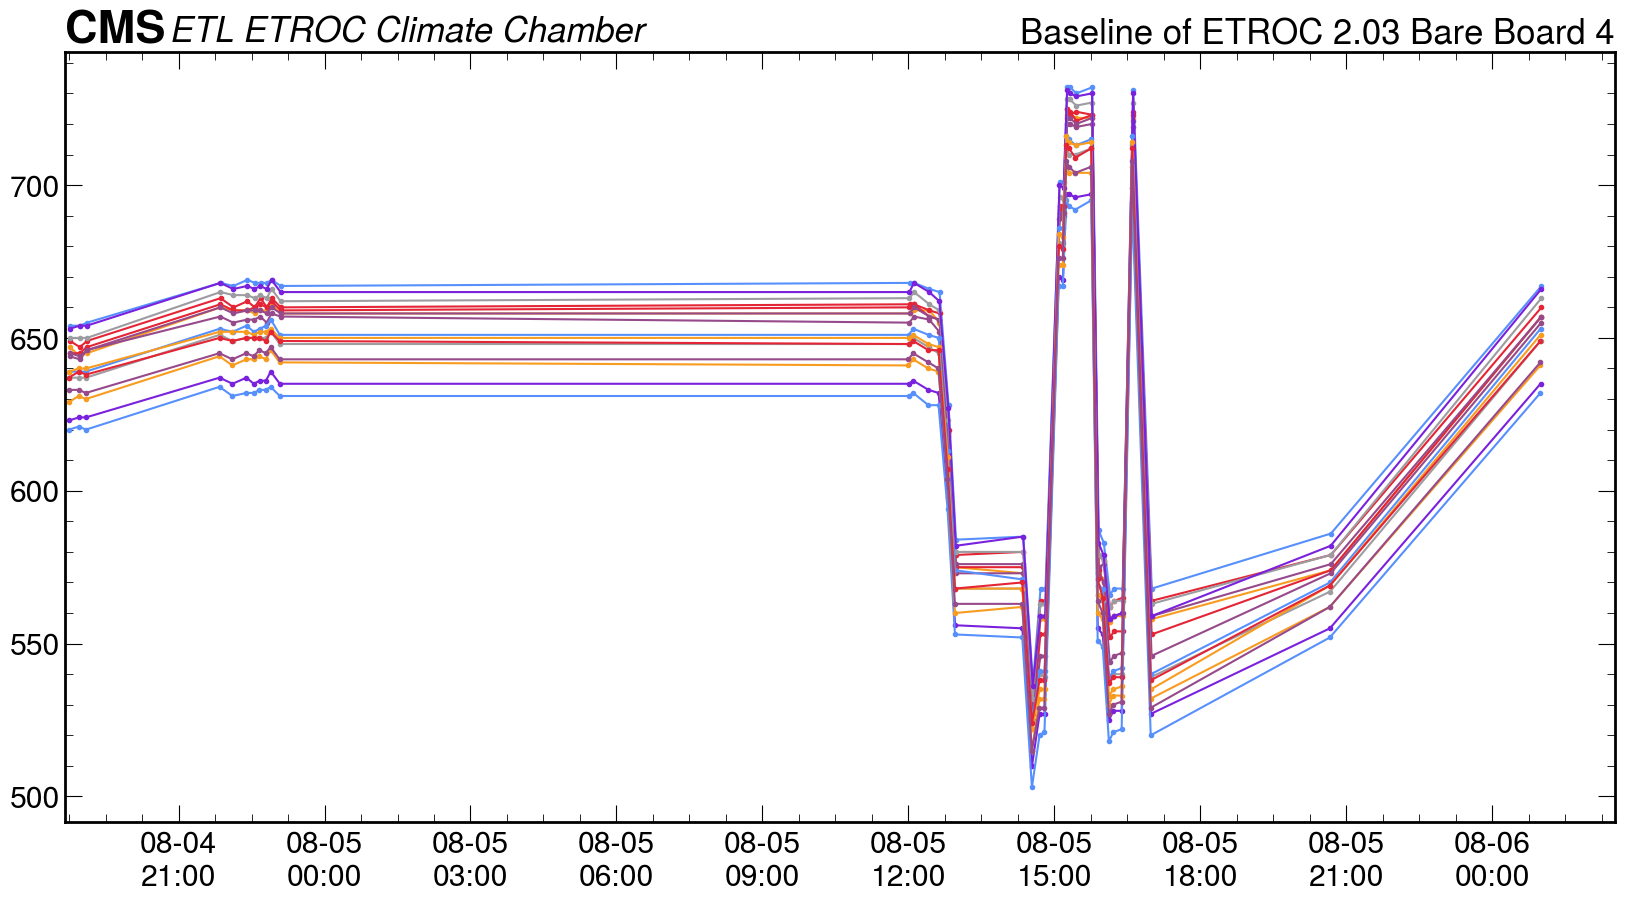

In [670]:
# p_col=[8,8,2,2]
# p_row=[0,2,0,2]
p_col = [7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8]
p_row = [15,14,13,12,3,2,1,0, 15,14,13,12,3,2,1,0]
pixel_plot_list = list(zip(p_row,p_col))

draw_dates = True
cut_time = pd.to_datetime('2024-08-04 18:40:00')

for iboard in baseline_df['chip_name'].unique():
    fig, ax = plt.subplots(figsize=(20, 10))
    hep.cms.text(loc=0, ax=ax, text="ETL ETROC Climate Chamber", fontsize=25)
    ax.set_title(f'Baseline of {config_dict[iboard]["plot_title"]}', size=17, loc="right", fontsize=25)
    date_form = mdates.DateFormatter("%m-%d\n%H:%M")
    ax.xaxis.set_major_formatter(date_form)
    for row,col in pixel_plot_list:
        interest_df = baseline_df.loc[baseline_df['chip_name']==iboard]
        tmp_df = interest_df.loc[(interest_df['col']==col) & (interest_df['row']==row)].reset_index(drop=True)
        tmp_df = tmp_df.loc[tmp_df['timestamp'] > cut_time]
        ax.plot(tmp_df['timestamp'], tmp_df['baseline'], label=f'Pixel R{row} C{col}', marker='.')
    ax.set_xlim(left=cut_time)
    # ax.legend()

## Temperature

In [671]:
con = sqlite3.connect('/home/daq/ETROC2/ETROC-History/CERN_Aug_2024_CC_CTS/vol_monitoring.sqlite')
adc_df = pd.read_sql_query("SELECT * from vol_monitoring", con)
adc_df['timestamp'] = pd.to_datetime(adc_df['timestamp'], format='%Y-%m-%d %H:%M:%S')
adc_df['timestamp'] = adc_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
adc_df['timestamp'] = pd.to_datetime(adc_df['timestamp'])

(19939.729166666668, 19941.131474537036)

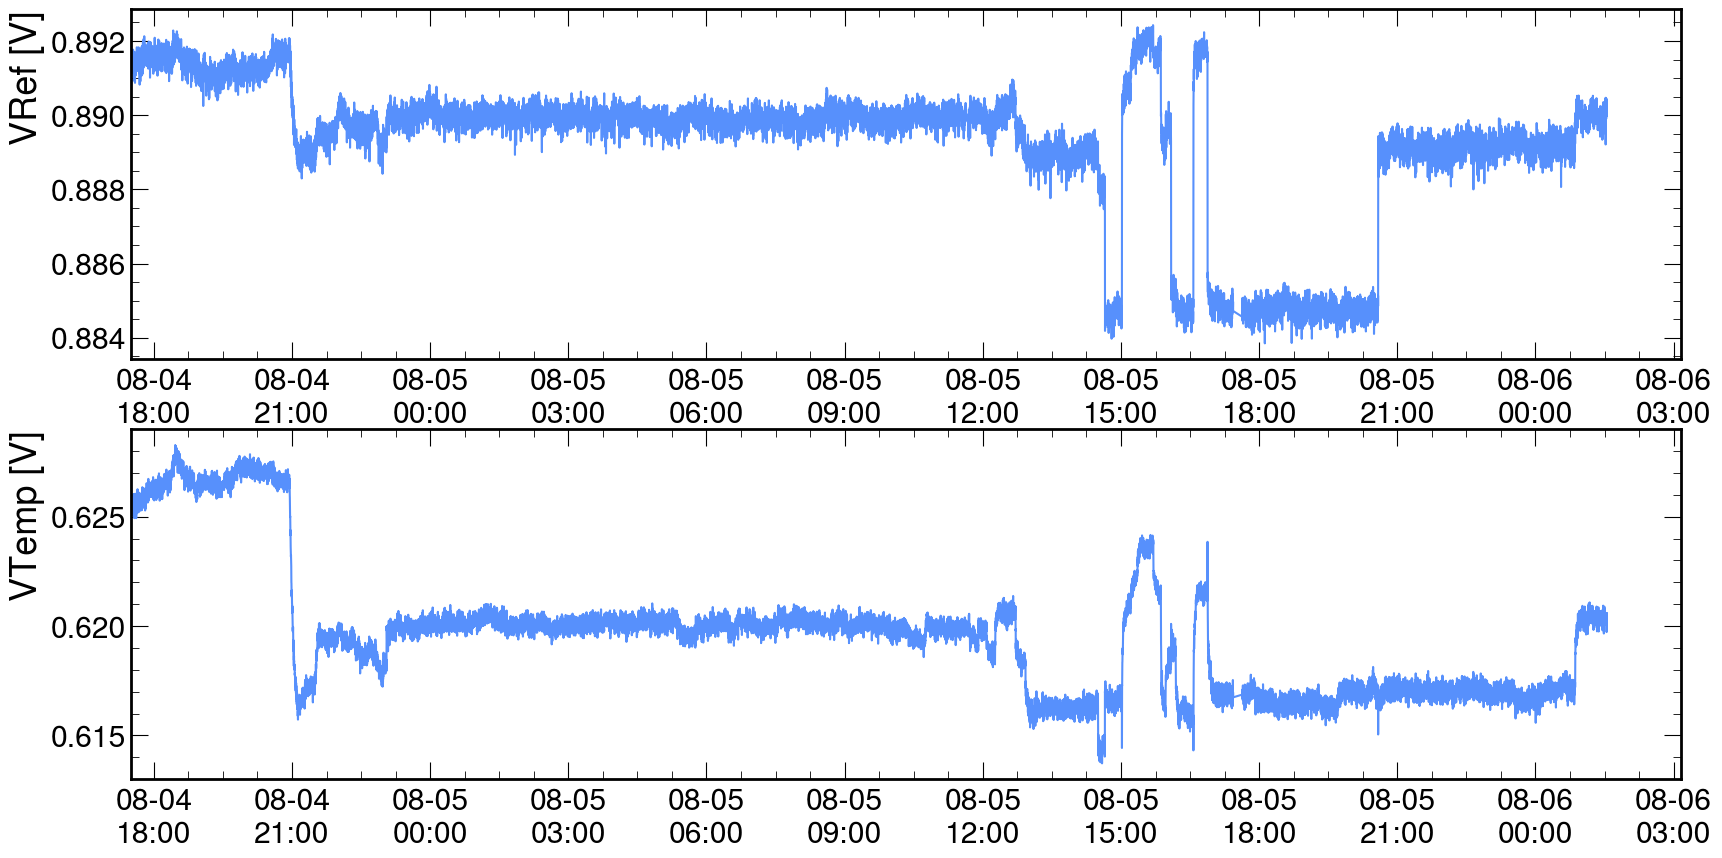

In [672]:
cut_time = pd.to_datetime('2024-08-04 17:30:00')
date_form = mdates.DateFormatter("%m-%d\n%H:%M")
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

ax[0].xaxis.set_major_formatter(date_form)
tmp_df = adc_df.loc[adc_df['Instrument']=='VRef']
ax[0].plot(tmp_df['timestamp'], tmp_df['voltage'])
# ax[0].legend(loc='best')
ax[0].set_ylabel('VRef [V]')
# ax[0].set_ylim(0.8, None)
ax[0].set_xlim(left=cut_time)

ax[1].xaxis.set_major_formatter(date_form)
tmp_df = adc_df.loc[adc_df['Instrument']=='VTemp']
ax[1].plot(tmp_df['timestamp'], tmp_df['voltage'])
# ax[1].legend(loc='best')
ax[1].set_ylabel('VTemp [V]')
# ax[1].set_ylim(0.8, None)
ax[1].set_xlim(left=cut_time)

# Power Monitoring

In [673]:
start_time = datetime.datetime(2024, 6, 25, 12, 30, 0)
end_time = datetime.datetime(2024, 6, 25, 19, 0, 0)

power_file = Path("/home/daq/ETROC2/ETROC-History/CERN_Aug_2024_CC_CTS/PowerHistory_v2.sqlite")

power_connections = {
    "ET2.03 Bare Board 4": {
        "Analog": "Analog",
        "Digital": "Digital",
    },
}

Timestamps in power database file cover range:
Min: 2024-08-04 17:27:05.889283
Max 2024-08-06 01:33:04.280128


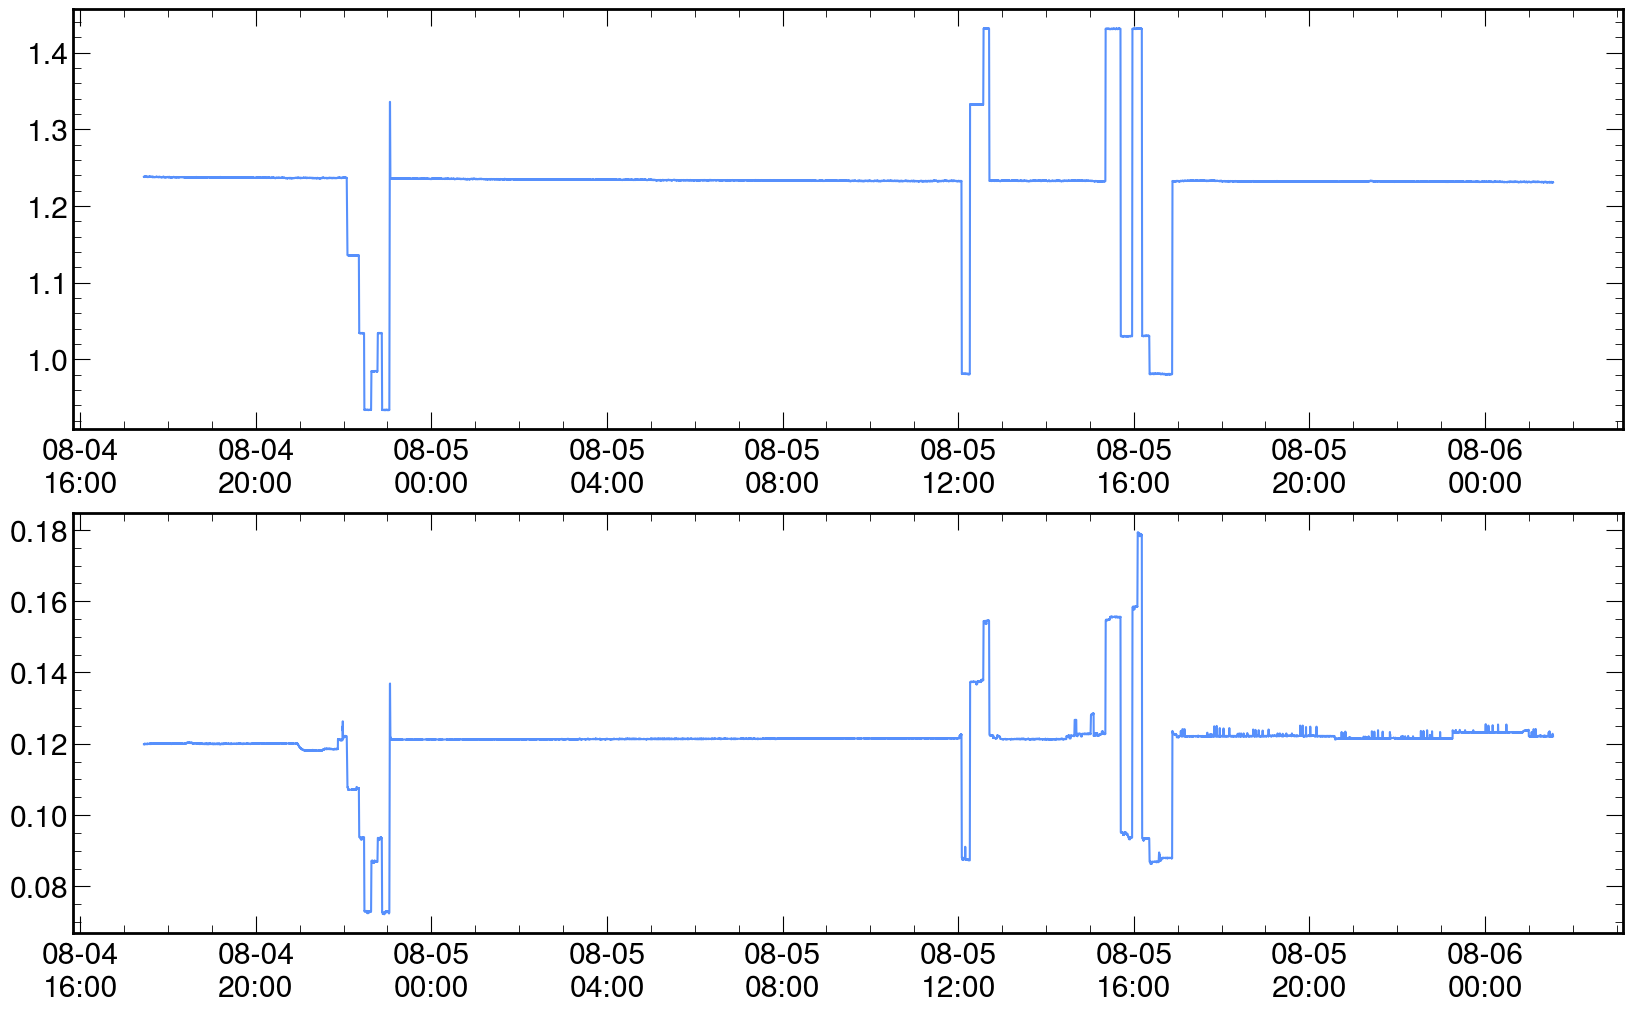

In [674]:
with sqlite3.connect(power_file) as sqlite3_connection:
    data_df = pd.read_sql('SELECT * FROM power_v2', sqlite3_connection, index_col=None)
    data_df['Time'] = pd.to_datetime(data_df['timestamp'], format='mixed')

    # Remove data that is outside the range of the campaign
    # data_df = data_df.loc[data_df['Time'] >= start_time]
    # data_df = data_df.loc[data_df['Time'] <= end_time].copy()

    data_df['V'] = (data_df['V'].str.replace('V','')).astype(float)
    data_df['I'] = (data_df['I'].str.replace('A','')).astype(float)

    print("Timestamps in power database file cover range:")
    print("Min:", data_df['Time'].min())
    print("Max", data_df['Time'].max())

    tmp_df = data_df.loc[data_df['Channel'] == 'Digital']
    
    fig, axes = plt.subplots(2, 1, figsize=(20, 12))
    date_form = mdates.DateFormatter("%m-%d\n%H:%M")
    axes[0].xaxis.set_major_formatter(date_form)
    axes[0].plot(tmp_df['Time'], tmp_df['V'])
    # axes[0].set_ylim(0.9, 1.5)
    axes[1].xaxis.set_major_formatter(date_form)
    axes[1].plot(tmp_df['Time'], tmp_df['I'])


    #print(data_df)

    # vref_df = data_df.loc[data_df['Channel'] == 'VRef']
    # wsana_df = data_df.loc[data_df['Channel'] == 'WSAnalog']
    # wsdig_df = data_df.loc[data_df['Channel'] == 'WSDigital']

Timestamps in power database file cover range:
Min: 2024-08-04 17:27:05.889283
Max 2024-08-06 01:33:04.280128


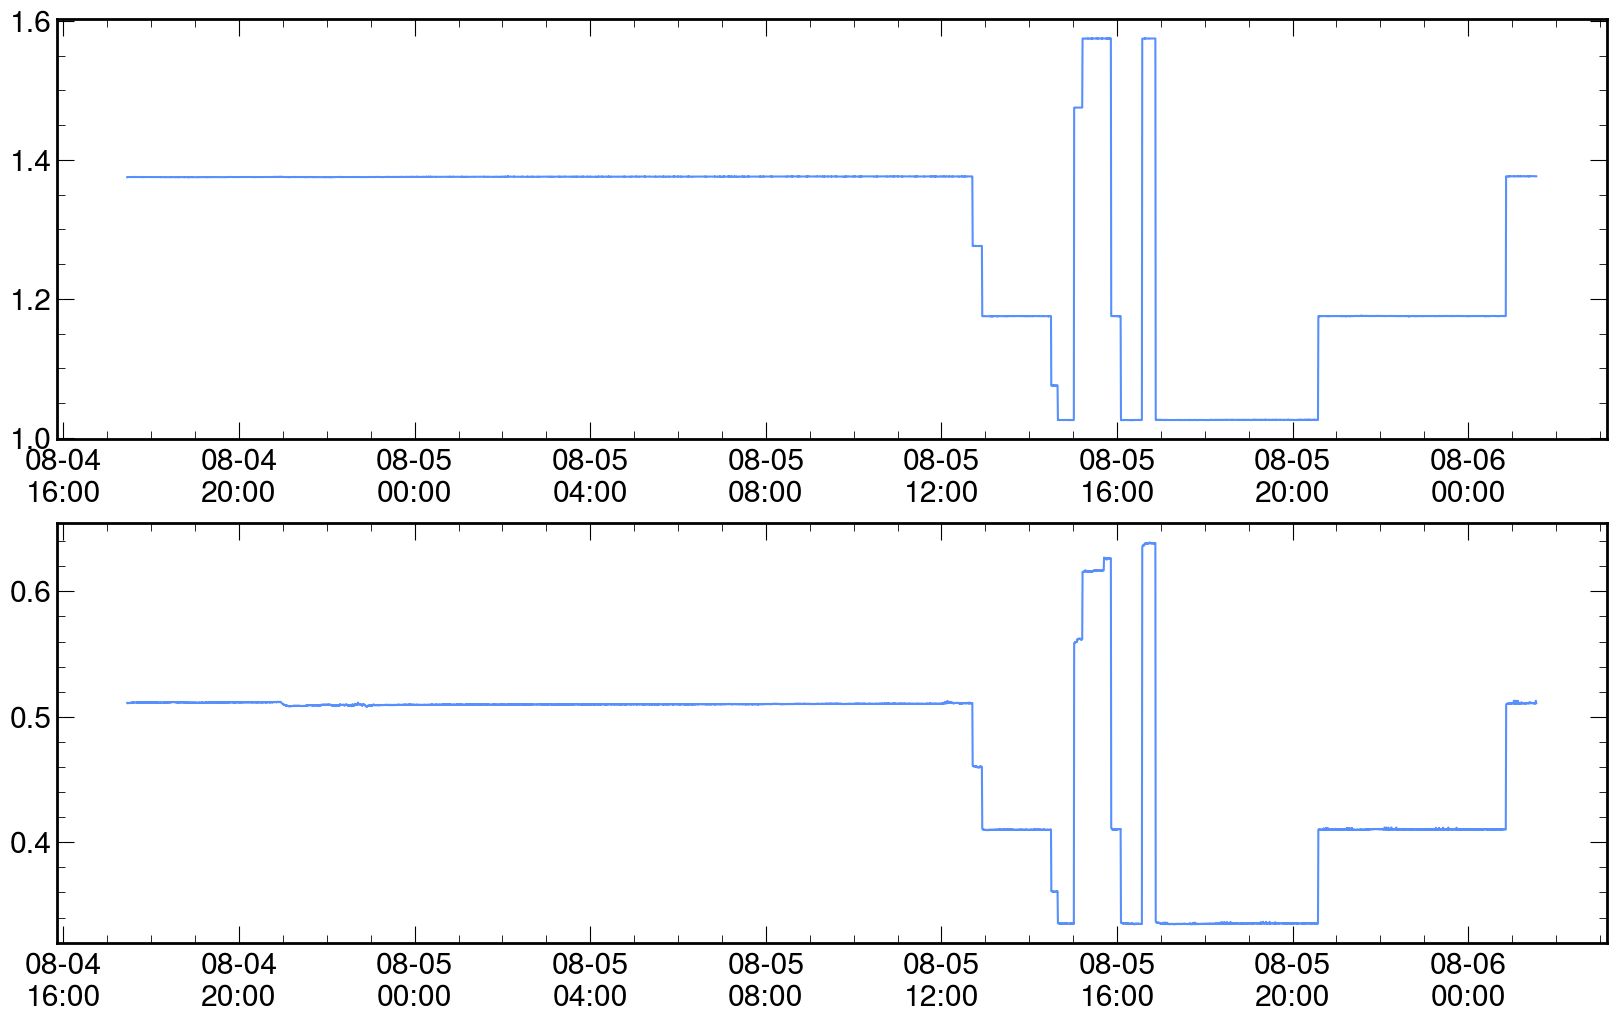

In [675]:
with sqlite3.connect(power_file) as sqlite3_connection:
    data_df = pd.read_sql('SELECT * FROM power_v2', sqlite3_connection, index_col=None)
    data_df['Time'] = pd.to_datetime(data_df['timestamp'], format='mixed')

    # Remove data that is outside the range of the campaign
    # data_df = data_df.loc[data_df['Time'] >= start_time]
    # data_df = data_df.loc[data_df['Time'] <= end_time].copy()

    data_df['V'] = (data_df['V'].str.replace('V','')).astype(float)
    data_df['I'] = (data_df['I'].str.replace('A','')).astype(float)

    print("Timestamps in power database file cover range:")
    print("Min:", data_df['Time'].min())
    print("Max", data_df['Time'].max())

    tmp_df = data_df.loc[data_df['Channel'] == 'Analog']
    
    fig, axes = plt.subplots(2, 1, figsize=(20, 12))
    date_form = mdates.DateFormatter("%m-%d\n%H:%M")
    axes[0].xaxis.set_major_formatter(date_form)
    axes[0].plot(tmp_df['Time'], tmp_df['V'])
    # axes[0].set_ylim(0.9, 1.5)
    axes[1].xaxis.set_major_formatter(date_form)
    axes[1].plot(tmp_df['Time'], tmp_df['I'])


    #print(data_df)

    # vref_df = data_df.loc[data_df['Channel'] == 'VRef']
    # wsana_df = data_df.loc[data_df['Channel'] == 'WSAnalog']
    # wsdig_df = data_df.loc[data_df['Channel'] == 'WSDigital']